## [1]. Importing the relative modules

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import re
import numpy as np
import os
import time
import json
import pickle

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from glob import glob
from PIL import Image

## [2]. Dataset download & preprocess

#### Download dataset

In [ ]:
# [√] - files 

# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip', cache_subdir=os.path.abspath('.'),
    origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip', extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip', cache_subdir=os.path.abspath('.'),
    origin='http://images.cocodataset.org/zips/train2014.zip', extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 327s 0us/step


In [ ]:
# [√]
# Using with open can avoid cumbersome try...finally, 
# and will automatically call f.close().'r' means open in read-only mode
with open(annotation_file, 'r') as f:
    annotations = json.load(f)
# annotation is of dict type

#### Combine captions with the same image ID

In [ ]:
# [√]

# Create a dictionary dict corresponding to image and caption
# i.e.: When the key in the dictionary does not exist but is searched, the returned value is not a keyError but a default value
image_path_to_caption = collections.defaultdict(list)
# at this time, the return value of image_caption_dict[1] should be a'[]', len(dict)=0

print(len(image_path_to_caption))
print(image_path_to_caption[1])
print(image_path_to_caption[10])

0
[]
[]


In [ ]:
# [√]
# Important operation -> Combine captions with the same photo ID

# Remember to clear the array list

i = 0
for val in annotations['annotations']:
  # literal format string
  caption = f"<start> {val['caption']} <end>"  # Directly pass in the caption field in json
  
  # Take the ['image_id'] field from json and send it to the previous string template. 
  # The reason for using% here is to unify the number of digits to 12.
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])

  # print(caption)
  # print(image_path)
  # print(image_path_to_caption[image_path])

  image_path_to_caption[image_path].append(caption)
  # print(image_path_to_caption[image_path])

  if i % 10 == 0:
    print(">>> Index: ", i, end='\r')
  i += 1
  # print("------------")

print(">>> I:", len(annotations['annotations']))
print(len(image_path_to_caption))

>>> I: 414113
82785


#### Store image path as list

In [ ]:
# [√]
# Store image path as list
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

train_image_paths = image_paths[:30000] # No interception is required in the formal operation / save time at trial stage
print(len(train_image_paths))

30000


In [ ]:
len(image_paths)

82785

In [ ]:
# [√]

# fullfil all the captions & img_path
train_captions = []  # put all the captions
img_name_vector = []

i = 0
for image_path in train_image_paths:
  # One image corresponds to multiple captions, where caption_list corresponds to one image
  caption_list = image_path_to_caption[image_path] 
  train_captions.extend(caption_list)
  # Here represents the [image_path] name of the number of len(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

  # print(len(image_path_to_caption[image_path]))
  # print(caption_list) 
  # output the caption of each img, the number in front means there are several captions, most of them are 5

  if i % 10 == 0:
    print(">>> Index: ", i, end='\r')
  i += 1

<start> A man riding skis down the side of a snow covered ski slope. <end>
<start> A man is skiing down a snow covered hill.  <end>
<start> a man is skiing on a slope with a gun on his back <end>
/content/train2014/COCO_train2014_000000032339.jpg


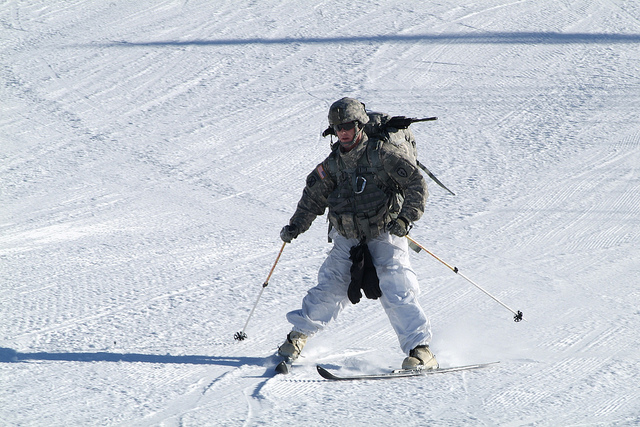

In [ ]:
# Check
print(train_captions[0])
print(train_captions[1])
print(train_captions[2])
print(img_name_vector[0])
Image.open(img_name_vector[0])

## [3]. Preprocess the images using Inception-V3

#### Get the Interception-V3 model

In [ ]:
# [√]

# image load
def load_image(image_path):
    img = tf.io.read_file(image_path)  # convert to string type tensor
    img = tf.image.decode_jpeg(img, channels=3)  # decode the picture into unit8 tensor
    img = tf.image.resize(img, (299, 299))  # resizing - img should meet the size specified by inception-v3
    img = tf.keras.applications.inception_v3.preprocess_input(img)  # normalize the image so that it contains pixels in [-1, 1]  

    return img, image_path

In [ ]:
# Build inception-v3 model
# The shape of the last convolutional layer of iv3 is (8*8*2048)
# Feed each picture into the network and store the result vector in the dictionary (image_name --> feature_vector)

image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input  # Get the input of the model-return a tensor
hidden_layer = image_model.layers[-1].output # hidden_layer is the output of the last layer of iv3

# build a model based on input and output
# used to extract image features
image_features_extract_model = tf.keras.Model(inputs=new_input, outputs=hidden_layer)

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
print(new_input)
print(hidden_layer)

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 2048), dtype=tf.float32, name=None), name='mixed10/concat:0', description="created by layer 'mixed10'")


#### Pre-process each image with InceptionV3 and cache the output to disk.

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector)) # len=1000

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16) # apply load_image()

i = 0
for img, path in image_dataset: # len=63 (1000/16 ~=)
  # print(path)
  # use custom model to process img to get features
  batch_features = image_features_extract_model(img) 
  batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
  # print(batch_features.shape) # 16, 64, 2048 (16 is because the batch is 16, that is, a data item has 16 pictures)

  for bf, p in zip(batch_features, path): # decode and store each data in the data item of size 16 once
    # print(p)
    path_of_feature = p.numpy().decode("utf-8")
    # print(path_of_feature, bf)
    np.save(path_of_feature, bf.numpy()) # use .numpy, just take the matrix

  if i % 1 == 0:
    print(">>> Index: ", i, end='\r')
  i += 1

In [ ]:
path_of_feature

'/content/train2014/COCO_train2014_000000581903.jpg'

## [4]. Tokenizer establishment (Captions content processing)

In [ ]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
        oov_token="<unk>",
        filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ') # special char

tokenizer.fit_on_texts(train_captions)

config = tokenizer.get_config()

In [ ]:
print(config)

{'num_words': 5000, 'filters': '!"#$%&()*+.,-/:;=?@[\\]^_`{|}~ ', 'lower': True, 'split': ' ', 'char_level': False, 'oov_token': '<unk>', 'document_count': 150081, 'word_counts': '{"<start>": 150081, "a": 248537, "man": 18628, "riding": 4511, "skis": 1407, "down": 5906, "the": 49784, "side": 3110, "of": 51614, "snow": 2996, "covered": 1838, "ski": 777, "slope": 956, "<end>": 150081, "is": 24868, "skiing": 897, "hill": 973, "on": 54573, "with": 39175, "gun": 38, "his": 4963, "back": 1376, "wearing": 2585, "backpack": 190, "skier": 558, "in": 46806, "military": 173, "attire": 53, "and": 35785, "coming": 367, "one": 2159, "giraffe": 2096, "standing": 10930, "still": 121, "while": 3841, "grazing": 862, "branch": 285, "grass": 3324, "leaves": 386, "its": 1560, "mouth": 506, "grassy": 1062, "field": 5335, "near": 4922, "some": 6226, "trees": 1816, "sticking": 177, "out": 2499, "wilderness": 53, "looking": 3115, "away": 204, "from": 2373, "camera": 787, "young": 4307, "girl": 2388, "glasses":

In [ ]:
# [√]

# pad stands for padding characters, that is, the characters used when filling the length later.
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
print(tokenizer.word_index["<start>"])
print(tokenizer.word_index["<end>"])
print(tokenizer.word_index["<unk>"])
print(tokenizer.word_index['<pad>'])
print(tokenizer.index_word[2])

3
4
1
0
a


In [ ]:
# save the tokenizer  
joblib.dump(tokenizer, 'data_tokenizer.pkl')  # tok model save
# tokenizer = joblib.load('dataFile.pkl') # tok model load

['data_tokenizer.pkl']

In [ ]:
# [√]
# Create the tokenized vectors, transforms each text in texts to a sequence of integers.
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post') # pad from the end

In [ ]:
print(train_seqs)
print(cap_vector)

[[3, 2, 124, 125, 69, 70, 71, 5, 49, 72, 2, 30, 17, 4], [3, 2, 126, 69, 70, 6, 2, 30, 127, 10, 5, 73, 4], [3, 18, 42, 9, 7, 15, 6, 31, 74, 4], [3, 2, 75, 50, 11, 2, 9, 6, 128, 11, 129, 74, 4], [3, 2, 75, 51, 11, 2, 9, 6, 130, 76, 4], [3, 2, 131, 132, 50, 11, 5, 9, 133, 134, 4], [3, 20, 52, 6, 2, 32, 25, 8, 53, 11, 2, 135, 4], [3, 2, 54, 2, 32, 6, 2, 136, 137, 10, 5, 26, 4], [3, 2, 138, 17, 7, 52, 139, 10, 5, 140, 4], [3, 2, 14, 21, 8, 2, 9, 7, 141, 77, 4], [3, 2, 142, 33, 6, 78, 55, 42, 12, 4], [3, 2, 56, 6, 15, 12, 7, 143, 144, 79, 145, 4], [3, 2, 12, 7, 2, 146, 11, 147, 6, 56, 148, 10, 5, 149, 80, 150, 4], [3, 18, 151, 50, 11, 2, 152, 55, 12, 4], [3, 5, 153, 57, 20, 154, 7, 2, 155, 156, 157, 4], [3, 2, 33, 81, 7, 158, 6, 159, 160, 43, 4], [3, 2, 15, 161, 9, 7, 34, 27, 35, 162, 163, 4], [3, 2, 15, 9, 8, 2, 164, 7, 5, 82, 10, 4], [3, 2, 9, 7, 2, 34, 27, 36, 44, 7, 165, 83, 2, 166, 2, 16, 6, 2, 167, 4], [3, 2, 15, 9, 168, 83, 10, 5, 44, 4], [3, 2, 9, 169, 7, 170, 171, 172, 6, 2, 173, 17

In [ ]:
# [√]

# Calculates the max_length, which is used to store the attention weights
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

max_length = calc_max_length(train_seqs)

In [ ]:
max_length

51

## [5]. Split the data into training and testing

In [ ]:
# [√]

# make each img vector get its own multiple captions-img is the key, and one key has multiple values
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8) # 80% for training
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

In [ ]:
# [√]

# get train/val dataset by the key above
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt]) # get the number of capts of this image
  img_name_train.extend([imgt] * capt_len) # use the extension extend to add the same name of capt_len imgt
  cap_train.extend(img_to_cap_vector[imgt]) # put in imgt

# same as above
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(40015, 40015, 10004, 10004)

In [ ]:
img_name_train[0]

'/content/train2014/COCO_train2014_000000528756.jpg'

## [6]. Create a tf.data dataset for training


In [ ]:
# [√]

# set the training hyperparameter 
BATCH_SIZE = 64 
BUFFER_SIZE = 1000  
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE # (?)
# Shape of the vector extracted from Inception-V3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# self-defined func
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy') 

  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# buffer_size:
# For prefetch: represents the maximum number of elements that will be added to the buffer. 
# The buffer_size in Dataset.prefetch() only affects the time to generate the next element.
# -> represents the maximum number of buffer elements during prefetching. 
# Set to AUTOTUNE, then the buffer size will be dynamically adjusted
# For shuffle: represents the number of elements from the dataset, from which the new dataset will be sampled. 
# The buffer_size in Dataset.shuffle() will affect the randomness of your dataset, that is, the order in which the elements are generated.

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, inp=[item1, item2], Tout=[tf.float32, tf.int32]), # map_func self-defined
          num_parallel_calls=tf.data.AUTOTUNE) # num_parallel_calls so that map uses multiple threads to process elements

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)  # each data item thrown by the buffer contains batch_size data-to prevent data from overfitting
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  # creates a Dataset that prefetches elements from this dataset.
# This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.

In [ ]:
dataset

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.int32)>

## [7]. Model

#### Attention

In [ ]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()  # will use 3 dense models
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)  # must have the same number of digits as features (a, b, c)

        # - calculating the alignment vector (score)
        # - calculated between the previous decoder hidden state and each of the encoder’s hidden states
        # - measure the similarity between the environment vector and the current input vector; 
        # - find out which input information should be focused in the current environment;
        # - features: input vector. hwta: environment vector
        # - each value of the alignment vector is the score (or probability) of the corresponding word in the original sequence
        # - attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))) # same shape

        # - score shape == (batch_size, 64, 1) 
        # - a forward propagation network FNN, calculated
        # - score = self.V(attention_hidden_layer)
        score = self.V((tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))))  # score=eij, ( hj, st-1 )

        # - attention_weights shape == (batch_size, 64, 1)
        # - alignment function：compute attention weight，commonly use softmax to normalise.
        attention_weights = tf.nn.softmax(score, axis=1)  # atj

        # - context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)  # sum(atj*hj)

        return context_vector, attention_weights

#### CNN-RNN

In [ ]:
class CNN_Encoder(tf.keras.Model):
  def __init__(self, embedding_dim):
    super(CNN_Encoder, self).__init__()
    self.fc = tf.keras.layers.Dense(embedding_dim)
    # shape after fc == (batch_size, 64, embedding_dim)

  def call(self, x):
    x = self.fc(x)
    x = tf.nn.relu(x)
    return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                    return_sequences=True,
                    return_state=True,
                    recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)  # number of actual word in vocabulary

        self.attention = BahdanauAttention(self.units)

    @tf.function
    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        # - x is the input, start to word embedding
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        # - dimensiona reduction
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

    def get_config(self):
        return {"features": self.features, "hidden": self.hidden}

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
# tokenizer model save
joblib.dump(encoder, 'obj_encoder.pkl')
joblib.dump(decoder, 'obj_decoder.pkl')   

['obj_decoder.pkl']

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') # cross entropy loss function
# return Weighted loss float Tensor

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0)) # output True/False
  loss_ = loss_object(real, pred) # y_true, y_pred

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask # for padding 

  return tf.reduce_mean(loss_)

## [8]. Checkpoint

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=2)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## [9]. Training 


In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  print('target:', target)
  print('target-shape:', target.shape) # 64
  # -> [3, 3, 3, 3, 3, 3]
  print("test: ", [tokenizer.word_index['<start>']], target.shape[0], [tokenizer.word_index['<start>']] * target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
  print('dec_input:', dec_input)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor) # features extract

      # -Is target a caption? # target.shape[1] is the length of the caption (set to the maximum length)
      for i in range(1, target.shape[1]): 
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden) # get the predicted captions

          loss += loss_function(target[:, i], predictions) # judge the loss of target caption and yuce caption

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1) # ------- decoder_input, take the first i words as input

  total_loss = (loss / int(target.shape[1])) # the sum of the loss of the sentence, excluding the sentence length

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables # set trainable variables parameters

  gradients = tape.gradient(loss, trainable_variables) # Gradient calculation, training data includes encoder and decoder

  optimizer.apply_gradients(zip(gradients, trainable_variables)) # optimization

  return loss, total_loss

In [ ]:
EPOCHS = 20

# target: [64, 34], 64, length 20.
# 64 is there a single image with 64, or 64 images?\
# -> 64 images, each of the captions first use [3] that is <start> placeholder

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    # -enumerate: Combine traversable data into an index sequence
    # -batch: related to index
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

target: Tensor("target:0", shape=(64, 51), dtype=int32)
target-shape: (64, 51)
test:  [3] 64 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
dec_input: Tensor("ExpandDims:0", shape=(64, 1), dtype=int32)
target: Tensor("target:0", shape=(64, 51), dtype=int32)
target-shape: (64, 51)
test:  [3] 64 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
dec_input: Tensor("ExpandDims:0", shape=(64, 1), dtype=int32)
Epoch 1 Batch 0 Loss 1.9625
Epoch 1 Batch 100 Loss 1.0721
Epoch 1 Batch 200 Loss 0.9521
Epoch 1 Batch 300 Loss 0.8508
Epoch 1 Batch 400 Loss 0.9157
Epoch 1 Batch 500 Loss 0.8131
Epoch 1 Batch 600 Loss 0.6914
Epoch 1 Batch 700 Loss 0.7952
Epoch 1 Batch 800 Loss 0.6778
Epoch 1 Batch 900 Loss 0.7501
Epoch 

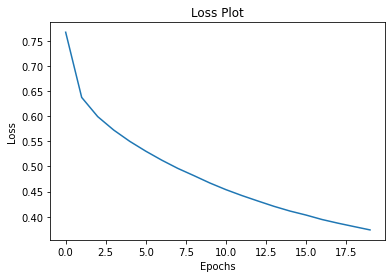

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
# View checkpoint (The colab folder is not displayed, you need to manually query and download.)
filePath = './checkpoints/train/'
os.listdir(filePath)

# Select the latest checkpoints, after saving, you can directly read their weights and then perform evaluation

['checkpoint',
 'ckpt-4.index',
 'ckpt-3.index',
 'ckpt-3.data-00000-of-00001',
 'ckpt-4.data-00000-of-00001']

In [ ]:
ckpt_manager.latest_checkpoint

'./checkpoints/train/ckpt-4'

In [ ]:
with zipfile.ZipFile('ckpt-6-data.zip', 'w') as z:
    z.write('./checkpoints/train/ckpt-4.data-00000-of-00001')

In [ ]:
with zipfile.ZipFile('ckpt-6-index.zip', 'w') as z:
    z.write('./checkpoints/train/ckpt-4.index')

In [ ]:
import zipfile
import os

# zipfilename is the name of the compressed package, dirname is the directory to be packaged
def compress_file(zipfilename, dirname): 
    if os.path.isfile(dirname):
        with zipfile.ZipFile(zipfilename, 'w') as z:
            z.write(dirname)
    else:
        with zipfile.ZipFile(zipfilename, 'w') as z:
            for root, dirs, files in os.walk(dirname):
                for single_file in files:
                    if single_file != zipfilename:
                        filepath = os.path.join(root, single_file)
                        z.write(filepath)

compress_file('checkpoints.zip', './checkpoints/')

In [ ]:
compress_file('encoder_data', '/content/encoder_weights.data-00000-of-00001')

## [10]. Captioning

In [ ]:
# Encapsulation: Pay attention to loading related items 
def evaluate(image):

    # attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1) # reset state of hidden layer at each evaluation

    # process the image with load_(including decoding, tensor, resize, normalize), and then upgrade
    temp_input = tf.expand_dims(load_image(image)[0], 0) 
    img_tensor_val = image_features_extract_model(temp_input)  # use the interception model to export features
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))  # dimension processing

    features = encoder(img_tensor_val)  # use custom CNN for encoding

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0) # pre input of decoder
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        # predictions is the possible output obtained after the decoder processes the image (it is a probability distribution)
        # attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() # get the id of the word with the highest probability
        result.append(tokenizer.index_word[predicted_id]) # get word by id

        if tokenizer.index_word[predicted_id] == '<end>': # when <end> is encountered, returns
            return result 

        dec_input = tf.expand_dims([predicted_id], 0) 
        # print(dec_input.shape())

    return result

In [ ]:
# Compare the caption of the picture itself with the predicted caption
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image, result, attention_plot)

print(image)

Real Caption: <start> two pastel <unk> buses parked on the street in a french city <end>
Prediction Caption: a bus parked in front of a clock tower in his hand outside a sidewalk <end>
/content/train2014/COCO_train2014_000000311926.jpg


## Below are not for AI developing


#### [For client developing and testing]

In [ ]:
image_path

'/root/.keras/datasets/image.jpg'

In [ ]:
from skimage import io
# img_src = 'https://pic4.zhimg.com/80/v2-ffeacfe2e1dd1be5d38dcc7e8ec0fb99_1440w.jpg'
img_src = 'https://image.freepik.com/free-photo/close-up-young-handsome-man-isolated_273609-35942.jpg'
image = io.imread(img_src)
io.imsave('./temp.jpg',image)
image = './temp.jpg'
# io.imshow(image)
# io.show()

In [ ]:
# image_url = 'https://pic4.zhimg.com/80/v2-ffeacfe2e1dd1be5d38dcc7e8ec0fb99_1440w.jpg'
image_url = img_src
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
image_path = image 
# result, attention_plot = evaluate(image_path)
result = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)
# opening the image
# Image.open(image_path)

49152/47271 [===============================] - 0s 0us/step
Prediction Caption: woman with a selfie <end>


In [ ]:
result

['a', 'cat', 'is', 'on', 'top', 'of', 'a', 'television', '<end>']

In [ ]:
encoder_1 = joblib.load('obj_encoder.pkl')
decoder_1 = joblib.load('obj_decoder.pkl')

In [ ]:
encoder_1

In [ ]:
encoder

In [ ]:
img_src = 'https://pic4.zhimg.com/80/v2-ffeacfe2e1dd1be5d38dcc7e8ec0fb99_1440w.jpg'
# img_src = 'https://image.freepik.com/free-photo/close-up-young-handsome-man-isolated_273609-35942.jpg'
image = io.imread(img_src)
io.imsave('./temp.jpg',image)
image = './temp.jpg'
# io.imshow(image)
# io.show()

# image_url = 'https://pic4.zhimg.com/80/v2-ffeacfe2e1dd1be5d38dcc7e8ec0fb99_1440w.jpg'
image_url = img_src
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
image_path = image 
# result, attention_plot = evaluate(image_path)
result = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)
# opening the image
# Image.open(image_path)

Prediction Caption: rat older desert rather framed painting lapel man escalator cheering burgers possible approaches skiiers architecture cub rubbing falcon thru grating use notepad pancakes engine leaps parsley pipes wildlife fences bouquet canoe approaches flavored thumbs weapon wide tee sets frisby lawn shepherd rustic silhouette frowning puddle semi scooters stunts no details differently


In [ ]:
# load ckpt

# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
ckpt.restore(ckpt_manager.latest_checkpoint)

In [ ]:
image

'./temp.jpg'

In [ ]:
decoder.save_weights('decoder_weights')
encoder.save_weights('encoder_weights')

In [ ]:
encoder_2 = CNN_Encoder(embedding_dim)
decoder_2 = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
encoder_2.load_weights('encoder_weights')
decoder_2.load_weights('decoder_weights')

In [ ]:
# Encapsulation: Pay attention to loading related items
def evaluate_2(image):
    # attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder_2.reset_state(batch_size=1)  # must reset the hidden state of the hidden layer each time

    temp_input = tf.expand_dims(load_image(image)[0], 0)  # process the image with load_(including decoding, tensor, resize, normalize), then                                                                                                                                                                                升维
    img_tensor_val = image_features_extract_model(temp_input)  # use Interception-v3 model extract image features                          
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))  # dimension processing

    features = encoder_2(img_tensor_val)  # use custom CNN for encoding

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)  # input of decoder
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder_2(dec_input, features, hidden)
        # predictions is the possible output obtained after the decoder processes the image (it is a probability distribution)
        # attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()  # get the word id with the highest probability
        result.append(tokenizer.index_word[predicted_id])  # find word by id

        if tokenizer.index_word[predicted_id] == '<end>':  # when the end character is encountered, return
            return result

        dec_input = tf.expand_dims([predicted_id], 0)
        # print(dec_input.shape())

    return result

In [ ]:
# image_url = 'https://pic4.zhimg.com/80/v2-ffeacfe2e1dd1be5d38dcc7e8ec0fb99_1440w.jpg' # 把猫显示为bus
image_url = 'https://image.freepik.com/free-photo/close-up-young-handsome-man-isolated_273609-35942.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
image_path = image 
# result, attention_plot = evaluate(image_path)
result = evaluate_2(image_path)
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)
# opening the image
# Image.open(image_path)

Prediction Caption: a bus driving towards a crosswalk <end>


In [ ]:
joblib.dump(tokenizer, 'tokenizer.pkl')

['tokenizer.pkl']

#### Check the images and the predicted captions

In [ ]:
from skimage import io

Prediction Caption: a man on a bike down a street <end>


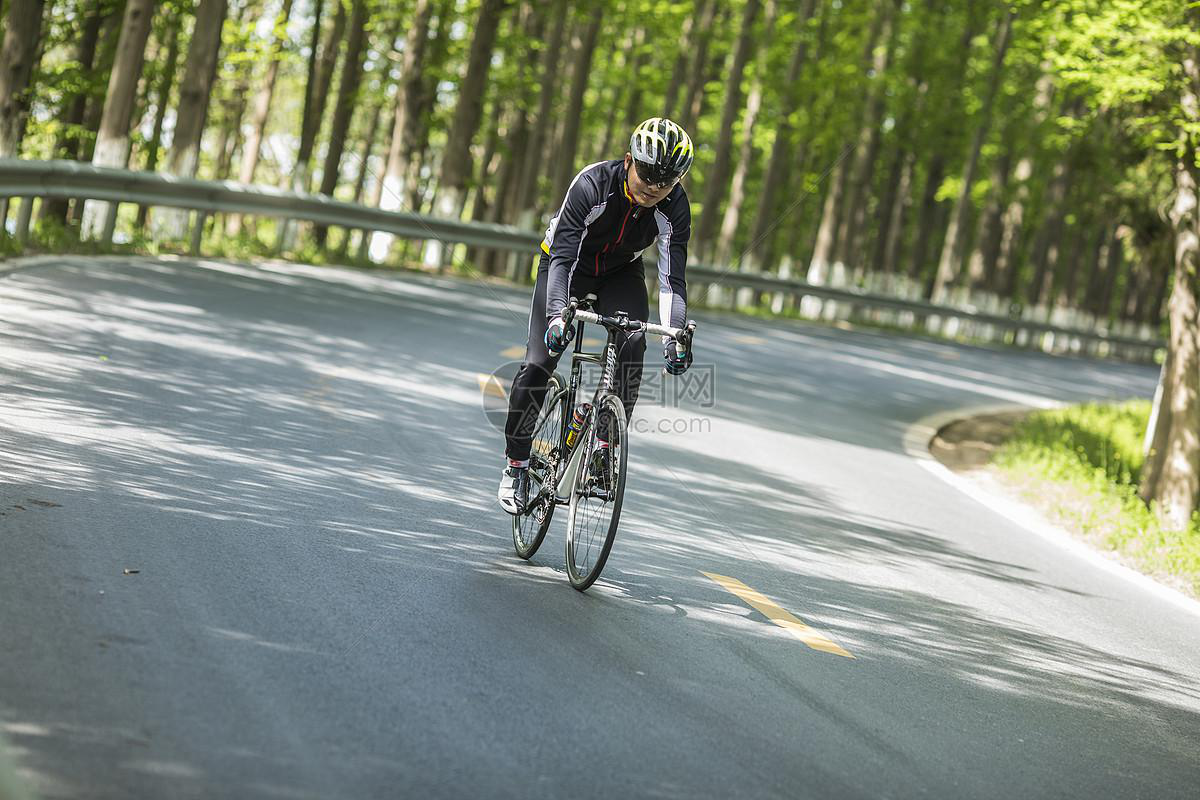

In [ ]:
# img_src = 'https://pic4.zhimg.com/80/v2-ffeacfe2e1dd1be5d38dcc7e8ec0fb99_1440w.jpg'
# img_src = 'https://image.freepik.com/free-photo/close-up-young-handsome-man-isolated_273609-35942.jpg'
# img_src = 'https://seopic.699pic.com/photo/50110/0938.jpg_wh1200.jpg'
# img_src = 'https://seopic.699pic.com/photo/50110/0947.jpg_wh1200.jpg'
# img_src = 'https://img95.699pic.com/xsj/0x/5y/o4.jpg'
img_src = 'https://seopic.699pic.com/photo/50089/1339.jpg_wh1200.jpg'
image = io.imread(img_src)
io.imsave('./temp.jpg',image)
image = './temp.jpg'
# io.imshow(image)
# io.show()

# image_url = 'https://pic4.zhimg.com/80/v2-ffeacfe2e1dd1be5d38dcc7e8ec0fb99_1440w.jpg'
image_url = img_src
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
image_path = image 
# result, attention_plot = evaluate(image_path)
result = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

Prediction Caption: a close up of a cat <end>


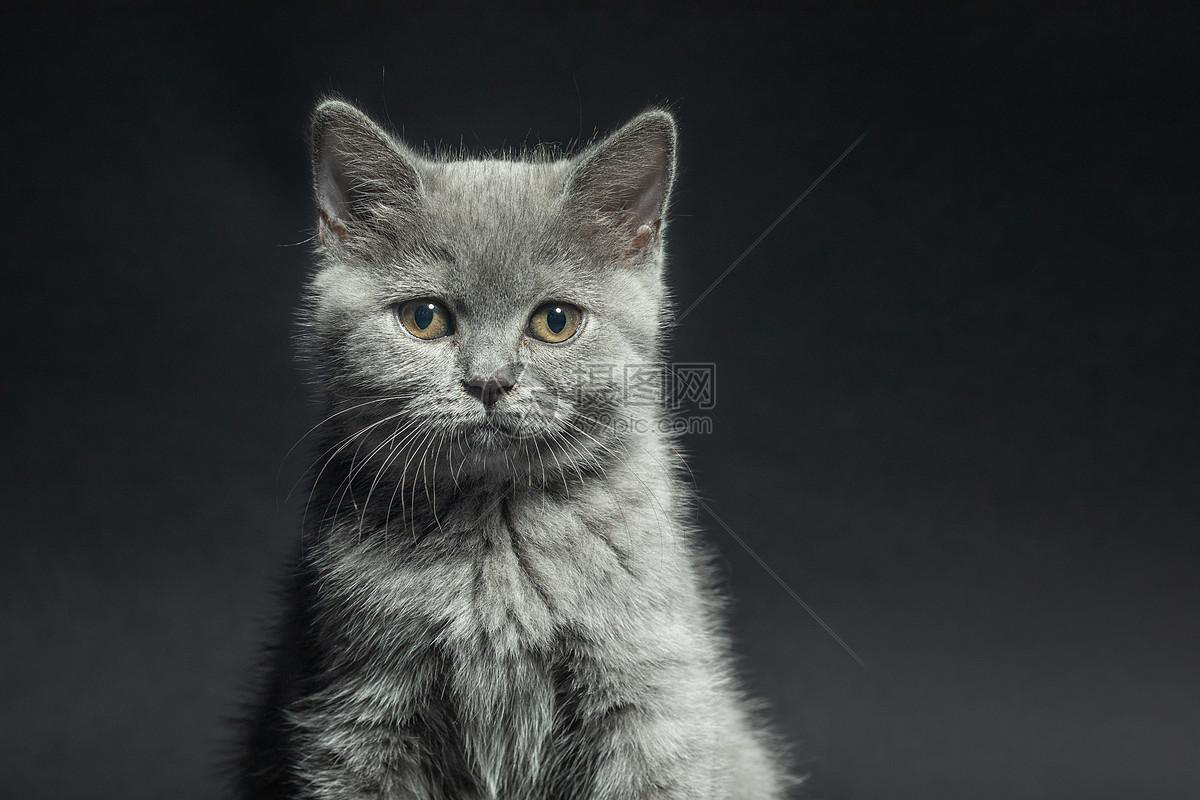

In [ ]:
# img_src = 'https://pic4.zhimg.com/80/v2-ffeacfe2e1dd1be5d38dcc7e8ec0fb99_1440w.jpg'
# img_src = 'https://image.freepik.com/free-photo/close-up-young-handsome-man-isolated_273609-35942.jpg'
# img_src = 'https://seopic.699pic.com/photo/50110/0938.jpg_wh1200.jpg'
# img_src = 'https://seopic.699pic.com/photo/50110/0947.jpg_wh1200.jpg'
# img_src = 'https://img95.699pic.com/xsj/0x/5y/o4.jpg'
img_src = 'https://seopic.699pic.com/photo/50102/4293.jpg_wh1200.jpg'
image = io.imread(img_src)
io.imsave('./temp.jpg',image)
image = './temp.jpg'
# io.imshow(image)
# io.show()

# image_url = 'https://pic4.zhimg.com/80/v2-ffeacfe2e1dd1be5d38dcc7e8ec0fb99_1440w.jpg'
image_url = img_src
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
image_path = image 
# result, attention_plot = evaluate(image_path)
result = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

Prediction Caption: a bike sits on a bike on a sandy beach <end>


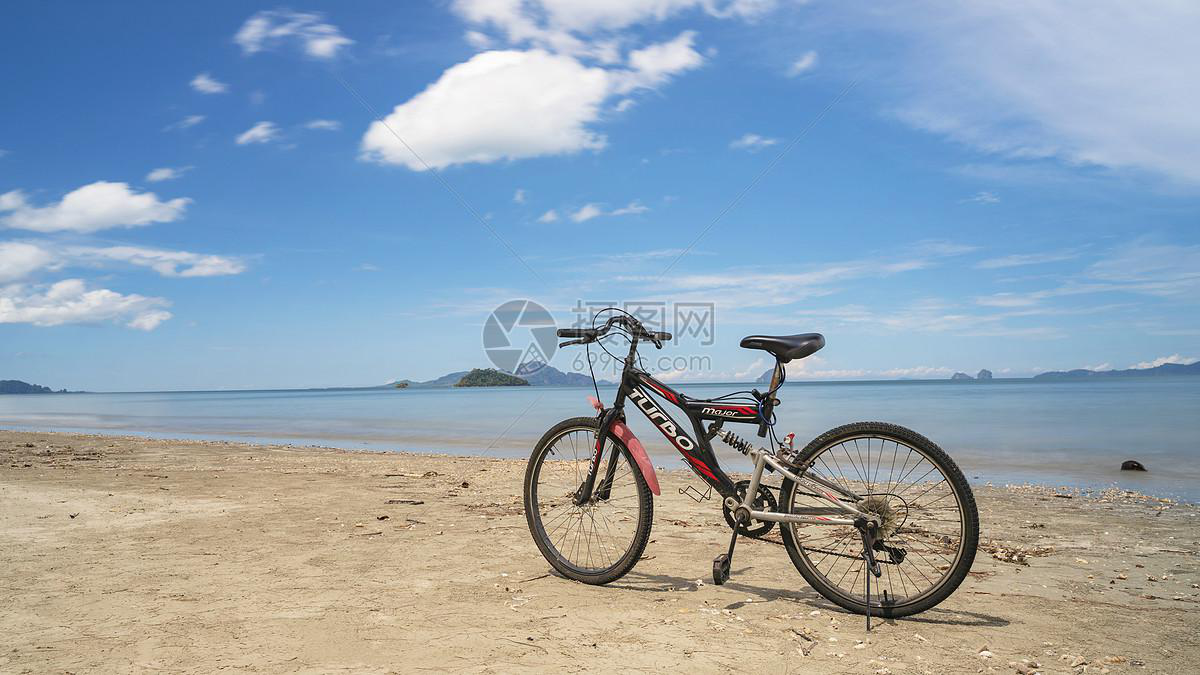

In [ ]:
# img_src = 'https://pic4.zhimg.com/80/v2-ffeacfe2e1dd1be5d38dcc7e8ec0fb99_1440w.jpg'
# img_src = 'https://image.freepik.com/free-photo/close-up-young-handsome-man-isolated_273609-35942.jpg'
# img_src = 'https://seopic.699pic.com/photo/50110/0938.jpg_wh1200.jpg'
# img_src = 'https://seopic.699pic.com/photo/50110/0947.jpg_wh1200.jpg'
# img_src = 'https://img95.699pic.com/xsj/0x/5y/o4.jpg'
img_src = 'https://seopic.699pic.com/photo/50160/6052.jpg_wh1200.jpg'
image = io.imread(img_src)
io.imsave('./temp.jpg',image)
image = './temp.jpg'
# io.imshow(image)
# io.show()

# image_url = 'https://pic4.zhimg.com/80/v2-ffeacfe2e1dd1be5d38dcc7e8ec0fb99_1440w.jpg'
image_url = img_src
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
image_path = image 
# result, attention_plot = evaluate(image_path)
result = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

Prediction Caption: a person on riding a bicycle <end>


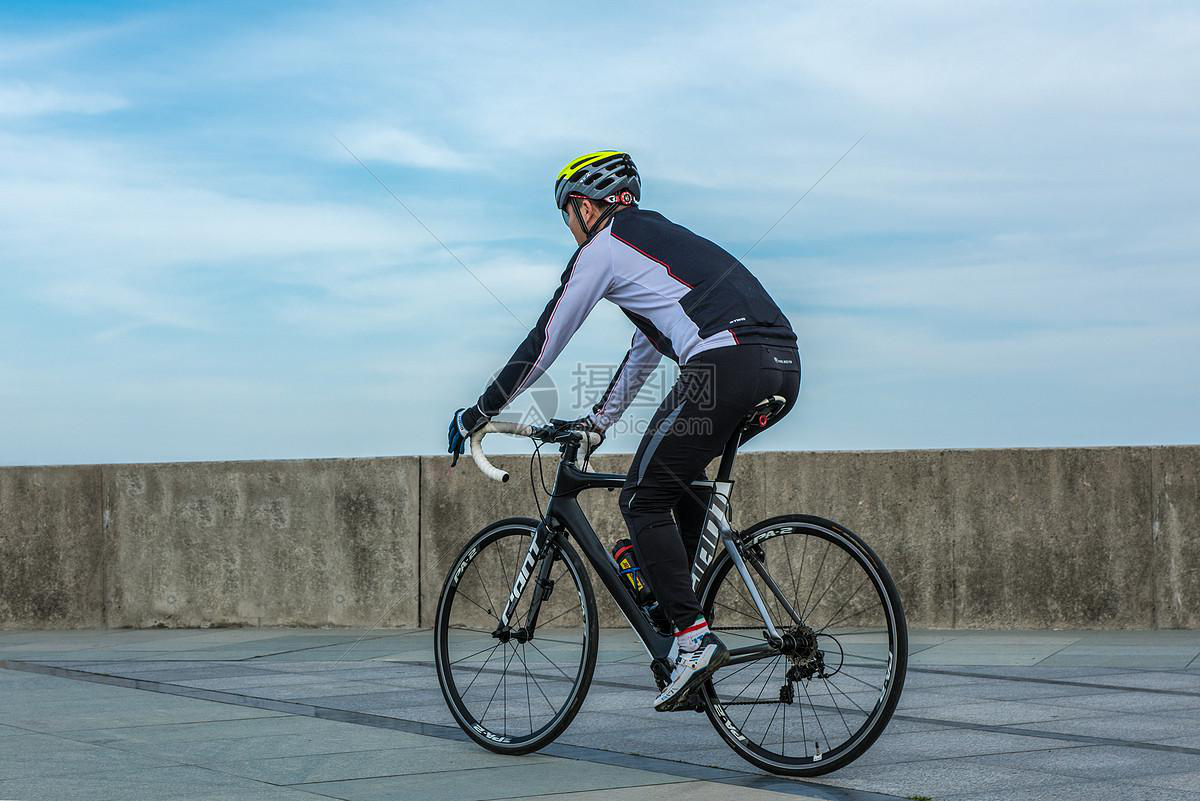

In [ ]:
# img_src = 'https://pic4.zhimg.com/80/v2-ffeacfe2e1dd1be5d38dcc7e8ec0fb99_1440w.jpg'
# img_src = 'https://image.freepik.com/free-photo/close-up-young-handsome-man-isolated_273609-35942.jpg'
# img_src = 'https://seopic.699pic.com/photo/50110/0938.jpg_wh1200.jpg'
# img_src = 'https://seopic.699pic.com/photo/50110/0947.jpg_wh1200.jpg'
# img_src = 'https://img95.699pic.com/xsj/0x/5y/o4.jpg'
img_src = 'https://seopic.699pic.com/photo/50089/1808.jpg_wh1200.jpg'
image = io.imread(img_src)
io.imsave('./temp.jpg',image)
image = './temp.jpg'
# io.imshow(image)
# io.show()

# image_url = 'https://pic4.zhimg.com/80/v2-ffeacfe2e1dd1be5d38dcc7e8ec0fb99_1440w.jpg'
image_url = img_src
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
image_path = image 
# result, attention_plot = evaluate(image_path)
result = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

Prediction Caption: a red bus is driving down a busy street <end>


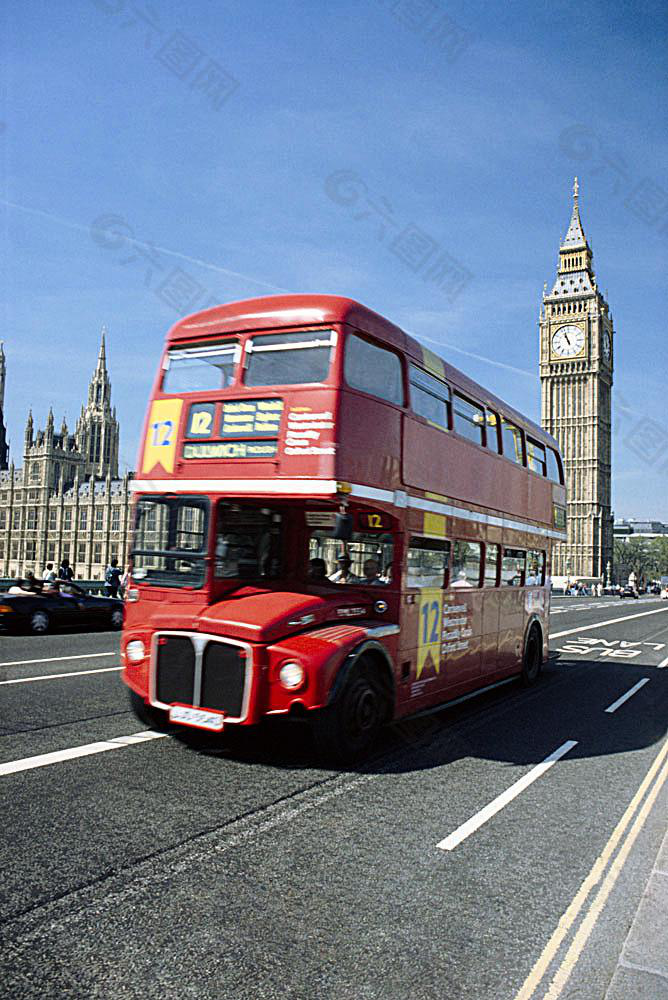

In [ ]:
# img_src = 'https://pic4.zhimg.com/80/v2-ffeacfe2e1dd1be5d38dcc7e8ec0fb99_1440w.jpg'
# img_src = 'https://image.freepik.com/free-photo/close-up-young-handsome-man-isolated_273609-35942.jpg'
# img_src = 'https://seopic.699pic.com/photo/50110/0938.jpg_wh1200.jpg'
# img_src = 'https://seopic.699pic.com/photo/50110/0947.jpg_wh1200.jpg'
# img_src = 'https://img95.699pic.com/xsj/0x/5y/o4.jpg'
img_src = 'https://photo.16pic.com/00/59/45/16pic_5945606_b.jpg'
image = io.imread(img_src)
io.imsave('./temp.jpg',image)
image = './temp.jpg' 
image_url = img_src
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
image_path = image 
# result, attention_plot = evaluate(image_path)
result = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

Prediction Caption: a red double decker <unk> with roof is coming down the road <end>


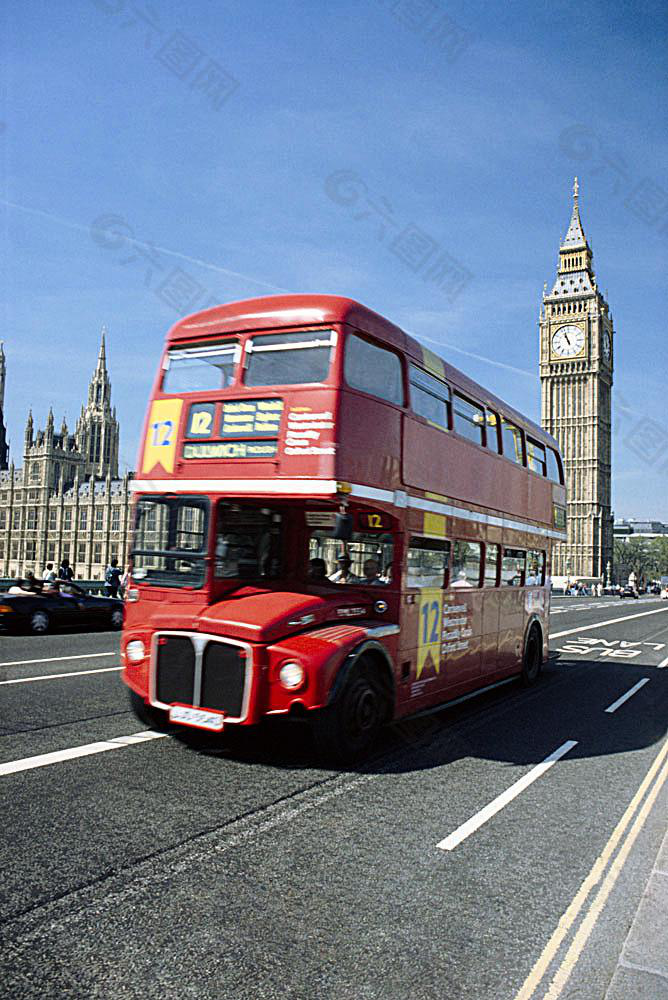

In [ ]:
# img_src = 'https://pic4.zhimg.com/80/v2-ffeacfe2e1dd1be5d38dcc7e8ec0fb99_1440w.jpg'
# img_src = 'https://image.freepik.com/free-photo/close-up-young-handsome-man-isolated_273609-35942.jpg'
# img_src = 'https://seopic.699pic.com/photo/50110/0938.jpg_wh1200.jpg'
# img_src = 'https://seopic.699pic.com/photo/50110/0947.jpg_wh1200.jpg'
# img_src = 'https://img95.699pic.com/xsj/0x/5y/o4.jpg'
img_src = 'https://photo.16pic.com/00/59/45/16pic_5945606_b.jpg'
image = io.imread(img_src)
io.imsave('./temp.jpg',image)
image = './temp.jpg' 
image_url = img_src
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)
image_path = image 
# result, attention_plot = evaluate(image_path)
result = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
# plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)